<a href="https://colab.research.google.com/github/dmarnet/Notebooks_experiments/blob/main/analise_modelos_IA_regress%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Modelos de Regressão

**Candidato:** Daniel Elbachá Marnet  
**LinkedIn:** [/in/danielmarnet](https://www.linkedin.com/in/danielmarnet/)  
**Email:** delmarnet1@gmail.com  
**Data:** 02 de dezembro de 2024  


# Previsão de Demanda com Séries Temporais

## Sumário

1. **Apresentação**

2. **Importação de Bibliotecas**

3. **Carregamento dos Dados**

4. **Análise Exploratória dos Dados (EDA)**

5. **Modelos**

6. **Análise de Resíduos**

7. **Variável Exógena**

8. **Ambiente de Produção para Machine Learning**

9. **Insights para o Negócio**

10. **README**

## 1. Apresentação

Este trabalho tem como objetivo desenvolver modelos preditivos para prever a demanda de vendas de um produto em uma distribuidora de medicamentos para os próximos 12 meses, utilizando técnicas de séries temporais e aprendizado de máquina. Busca-se melhorar a precisão das previsões, reduzindo os erros associados ao excesso ou falta de estoque, que impactam negativamente os custos operacionais. A proposta visa otimizar a gestão de estoques, permitindo decisões estratégicas mais eficazes e maior competitividade no mercado.

### Metodologia

**Análise Exploratória dos Dados (EDA):**
   - Importação e tratamento do dataset principal, incluindo transformação dos dados em formato adequado para análise temporal.
   - Visualização gráfica das vendas mensais, identificação de tendências, sazonalidades e possíveis anomalias.
   - Decomposição da série temporal em componentes de tendência, sazonalidade e resíduos.
   - Análise de autocorrelação para identificar lags significativos e avaliar a estacionariedade da série.

**Modelagem:**
   - **Modelos Tradicionais de Séries Temporais:**
     - **ARIMA:** Após verificar a estacionariedade da série, aplicou-se diferenciação e identificaram-se os parâmetros (p, d, q) ideais utilizando ACF e PACF.
     - **SARIMA:** Incorporou componentes sazonais ao modelo ARIMA, ajustando parâmetros sazonais (P, D, Q, s) com base na sazonalidade anual identificada.
     - **ETS (Suavização Exponencial):** Utilizou-se modelos aditivos para capturar tendência e sazonalidade presentes nos dados.

   - **Modelo Baseado em Aprendizado de Máquina:**
     - **LSTM:** Construção de uma rede neural LSTM com TensorFlow com uma arquitetura robusta, capaz de capturar dependências temporais complexas. Incluiu etapas de normalização dos dados, criação de sequências temporais e definição de hiperparâmetros otimizados.

   - **Modelo Prophet:**
     - Aplicação do modelo Prophet, desenvolvido pelo Facebook, adequado para séries com componentes de tendência e sazonalidade bem definidos.

**Validação Cruzada:**
   - Utilização do método **Time Series Split** para garantir a validação adequada dos modelos, respeitando a ordem temporal e evitando vazamento de informações.

**Métricas de Avaliação:**
   - Cálculo das métricas **MAE**, **MSE**, **RMSE**, **MAPE** e **WMAPE** para avaliar o desempenho dos modelos.
   - Destaque para o **WMAPE** como métrica principal, por ponderar o erro absoluto pelo total das vendas, oferecendo uma perspectiva mais alinhada com o impacto real no negócio.

**Análise de Resíduos:**
   - Avaliação dos resíduos dos modelos para verificar o cumprimento dos pressupostos estatísticos, incluindo testes de normalidade (Shapiro-Wilk) e análise de autocorrelação dos resíduos.

**Consideração de Variável Exógena:**
   - Importação de dados públicos do PIB como variável exógena, através de uma API do IBGE.
   - Integração dessa variável no modelo **SARIMAX**, buscando capturar influências externas na demanda.

**Ambiente de Produção para Machine Learning:**
   - Utilização do **MLflow** para rastreamento de experimentos, registro de parâmetros, métricas e modelos.
   - Sugestão de uso do **Apache Airflow** para agendamento de tarefas de treinamento e atualização dos modelos.
   - Consideração do **Amazon SageMaker** para implantação e gerenciamento dos modelos em produção.

**Estruturação do Código:**
   - O código foi estruturado utilizando **Programação Orientada a Objetos (POO)**, com a criação de classes para cada modelo, facilitando a organização e manutenção do código.

## 2. Importação de Bibliotecas

In [ ]:
# Instalação de pacotes ausentes
!pip install mlflow "dask[dataframe]" --quiet
# Instalação da biblioteca gdown
!pip install gdown

# Importação das bibliotecas
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from prophet import Prophet

import mlflow

import gdown

import warnings
warnings.filterwarnings('ignore')

# Configurações gerais de plots
%matplotlib inline
plt.style.use('ggplot')  # Substituir por outro estilo válido se necessário

## 3. Carregamento dos Dados

### Dataset Principal

O dataset está hospedado no Google Drive. Utiliza-se a biblioteca `gdown` para fazer o download direto.

In [ ]:
# URL do arquivo no Google Drive
url = 'https://drive.google.com/uc?id=16poKfYRxBaYwlFCp6x621M4TgBQGgvXf'

# Nome do arquivo de saída
output = 'dataset_principal.csv'

# Download do arquivo
gdown.download(url, output, quiet=False)

# Carregando o dataset principal
df = pd.read_csv('dataset_principal.csv', delimiter=',')  # Supondo que o separador seja tabulação

Downloading...
From: https://drive.google.com/uc?id=16poKfYRxBaYwlFCp6x621M4TgBQGgvXf
To: /content/dataset_principal.csv
100%|██████████| 51.7k/51.7k [00:00<00:00, 28.9MB/s]


## 4. Análise Exploratória dos Dados (EDA)

### Estrutura do Dataset

O dataset possui as seguintes colunas:

- `CATEGORIA`
- `PRODUTO`
- `FORNECEDOR`
- `COMPRADOR`
- `CENTROS DE DISTRIBUICAO`
- `DESCRICAO`
- `QTD DE CAIXAS`
- `Mar22` até `Mar24` (dados mensais de vendas)

### Visualização Inicial dos Dados

In [ ]:
# Visualizando as primeiras linhas do dataset
df.head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,MAR22,ABR22,MAI22,...,JUN23,JUL23,AGO23,SET23,OUT23,NOV23,DEZ23,JAN24,FEV24,MAR24
0,A,A,A,A,A,A,109,356,374,408,...,404,350,466,290,476,524,273,199,313,197
1,A,A,A,A,B,B,70,994,723,1310,...,1897,1840,2427,1655,1669,1970,1700,1895,1385,2243
2,B,B,B,B,C,C,123,74,65,71,...,144,57,69,165,129,153,149,145,125,132
3,B,C,C,C,D,D,196,520,466,603,...,496,568,443,304,408,372,315,447,610,776
4,A,D,A,A,E,E,99,37,1,78,...,75,60,85,13,45,24,8,64,79,96


In [ ]:
# Verificando informações gerais
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CATEGORIA                500 non-null    object
 1   PRODUTO                  500 non-null    object
 2   FORNECEDOR               500 non-null    object
 3   COMPRADOR                500 non-null    object
 4   CENTROS DE DISTRIBUICAO  500 non-null    object
 5   DESCRICAO                500 non-null    object
 6   QTD DE CAIXAS            500 non-null    int64 
 7   MAR22                    500 non-null    int64 
 8   ABR22                    500 non-null    int64 
 9   MAI22                    500 non-null    int64 
 10  JUN22                    500 non-null    int64 
 11  JUL22                    500 non-null    int64 
 12  AGO22                    500 non-null    int64 
 13  SET22                    500 non-null    int64 
 14  OUT22                    500 non-null    i

In [ ]:
# Verificando estatísticas descritivas
df.describe()

,QTD DE CAIXAS,MAR22,ABR22,MAI22,JUN22,JUL22,AGO22,SET22,OUT22,NOV22,...,JUN23,JUL23,AGO23,SET23,OUT23,NOV23,DEZ23,JAN24,FEV24,MAR24
count,500.000000,500.000000,500.000000,500.0000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000,500.000000,500.000000
mean,104.142000,346.214000,256.946000,370.8640,377.400000,369.646000,349.626000,309.992000,271.764000,340.622000,...,381.548000,385.842000,335.562000,271.966000,273.45000,351.172000,289.006000,306.52800,313.972000,322.302000
std,80.826925,1088.249907,690.142455,1309.8818,1208.011127,1291.151896,1113.839579,1111.134537,765.724598,940.956684,...,1102.948499,1068.121003,856.861584,697.109239,701.22524,1195.906484,743.002471,843.46736,891.374458,844.772685
min,7.000000,1.000000,1.000000,1.0000,1.000000,-10.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,2.000000,1.00000,1.000000,1.000000,2.00000,1.000000,5.000000
25%,62.000000,46.000000,48.000000,49.0000,47.000000,47.000000,47.750000,49.750000,47.000000,51.750000,...,54.750000,57.000000,55.750000,56.000000,55.75000,54.000000,51.000000,51.75000,58.750000,55.000000
50%,92.000000,83.000000,85.000000,86.5000,85.000000,87.000000,82.500000,84.000000,85.500000,91.000000,...,90.500000,93.000000,92.000000,91.500000,92.50000,90.500000,88.500000,97.00000,93.000000,97.000000
75%,125.250000,174.500000,154.250000,207.2500,204.000000,206.000000,199.500000,183.750000,173.750000,198.250000,...,203.000000,238.250000,211.250000,207.500000,198.25000,213.250000,199.000000,208.75000,194.750000,226.000000
max,1059.000000,12032.000000,7421.000000,16940.0000,16075.000000,18188.000000,13183.000000,19875.000000,10000.000000,10626.000000,...,11673.000000,11726.000000,7635.000000,9522.000000,8582.00000,20746.000000,10334.000000,11917.00000,10732.000000,8671.000000



### Tratamento dos Dados

#### Transformação dos Dados em Formato Longo

Para facilitar a análise temporal, transformaremos os dados em formato longo.

In [ ]:
# Converter colunas de meses para formato longo
df_long = pd.melt(df,
                  id_vars=['CATEGORIA', 'PRODUTO', 'FORNECEDOR', 'COMPRADOR',
                           'CENTROS DE DISTRIBUICAO', 'DESCRICAO', 'QTD DE CAIXAS'],
                  var_name='Mes',
                  value_name='Vendas')

# Visualizando o dataframe transformado
df_long.head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,Mes,Vendas
0,A,A,A,A,A,A,109,MAR22,356
1,A,A,A,A,B,B,70,MAR22,994
2,B,B,B,B,C,C,123,MAR22,74
3,B,C,C,C,D,D,196,MAR22,520
4,A,D,A,A,E,E,99,MAR22,37


#### Conversão da Coluna de Mês para Formato Datetime

In [ ]:
# Dicionário para traduzir os meses de português para inglês
month_translation = {
    "JAN": "Jan", "FEV": "Feb", "MAR": "Mar", "ABR": "Apr", "MAI": "May", "JUN": "Jun",
    "JUL": "Jul", "AGO": "Aug", "SET": "Sep", "OUT": "Oct", "NOV": "Nov", "DEZ": "Dec"
}

# Traduzir os meses na coluna 'Mes'
df_long['Mes'] = df_long['Mes'].replace(month_translation, regex=True)

# Adicionar o dia 1 e converter para datetime
df_long['Mes'] = pd.to_datetime(df_long['Mes'], format='%b%y')

# Ordenar por data
df_long.sort_values('Mes', inplace=True)

# Exibir o DataFrame ajustado
df_long.head()

,CATEGORIA,PRODUTO,FORNECEDOR,COMPRADOR,CENTROS DE DISTRIBUICAO,DESCRICAO,QTD DE CAIXAS,Mes,Vendas
0,A,A,A,A,A,A,109,2022-03-01,356
341,A,R,M,C,K,I,91,2022-03-01,77
340,B,E,E,C,K,H,130,2022-03-01,97
339,B,P,L,A,A,G,102,2022-03-01,66
338,B,P,L,A,S,W,114,2022-03-01,84


### Seleção de um Produto Específico

Para o desenvolvimento do modelo, seleciona-se um produto específico.

In [ ]:
# Listar as opções únicas de produtos na coluna 'PRODUTOS'
produtos_disponiveis = sorted(df_long['PRODUTO'].unique())

# Exibir os produtos disponíveis para o usuário selecionar
print("Produtos disponíveis para análise:")
for i, produto in enumerate(produtos_disponiveis, start=1):
    print(f"{i}. {produto}")

Produtos disponíveis para análise:
1. A
2. B
3. C
4. D
5. E
6. F
7. G
8. H
9. I
10. J
11. K
12. L
13. M
14. N
15. O
16. P
17. Q
18. R
19. S
20. T
21. U
22. V
23. W
24. X
25. Y
26. Z


In [ ]:
# Defina aqui o produto específico para a análise
produto = 'A'

# Selecionando um produto específico
produto_especifico = df_long[df_long['PRODUTO'] == produto]

# Agrupando as vendas mensais do produto
produto_vendas = produto_especifico.groupby('Mes')['Vendas'].sum().reset_index()

# Definindo a coluna 'Mes' como índice
produto_vendas.set_index('Mes', inplace=True)

# Visualizando a série temporal
produto_vendas.head()

,Vendas
Mes,
2022-03-01,20394
2022-04-01,14617
2022-05-01,27914
2022-06-01,19019
2022-07-01,18372


### Análise Gráfica da Série Temporal

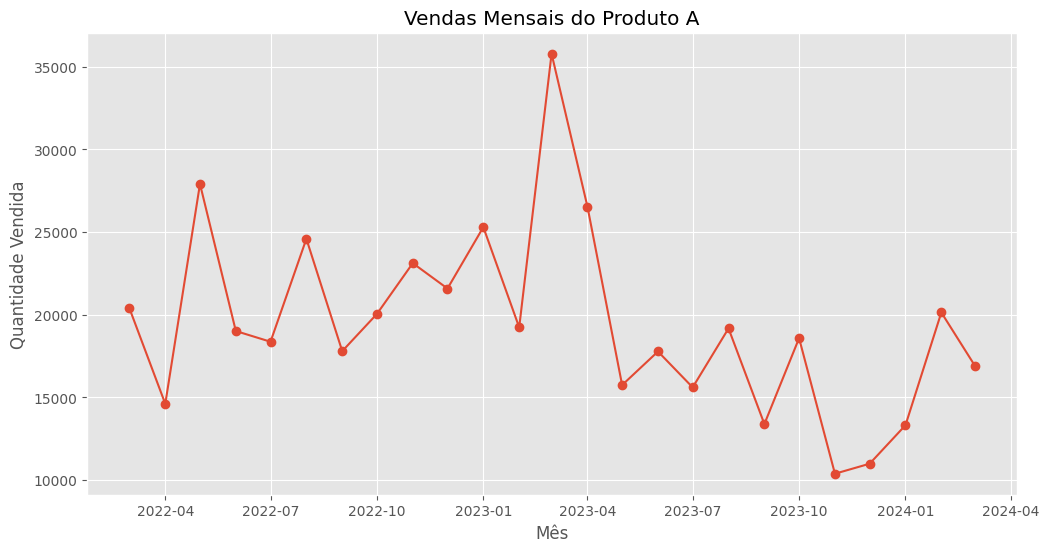

In [ ]:
# Plotando a série temporal de vendas
plt.figure(figsize=(12,6))
plt.plot(produto_vendas.index, produto_vendas['Vendas'], marker='o')
plt.title(f'Vendas Mensais do Produto {produto}')
plt.xlabel('Mês')
plt.ylabel('Quantidade Vendida')
plt.show()

**Observações:**

- **Tendência:** Observar se há tendência de crescimento ou declínio nas vendas.
- **Sazonalidade:** Identificar padrões sazonais recorrentes.
- **Anomalias:** Detectar picos ou quedas atípicas.

### Decomposição da Série Temporal

Utiliza-se a decomposição para separar a série em componentes de tendência, sazonalidade e resíduos.

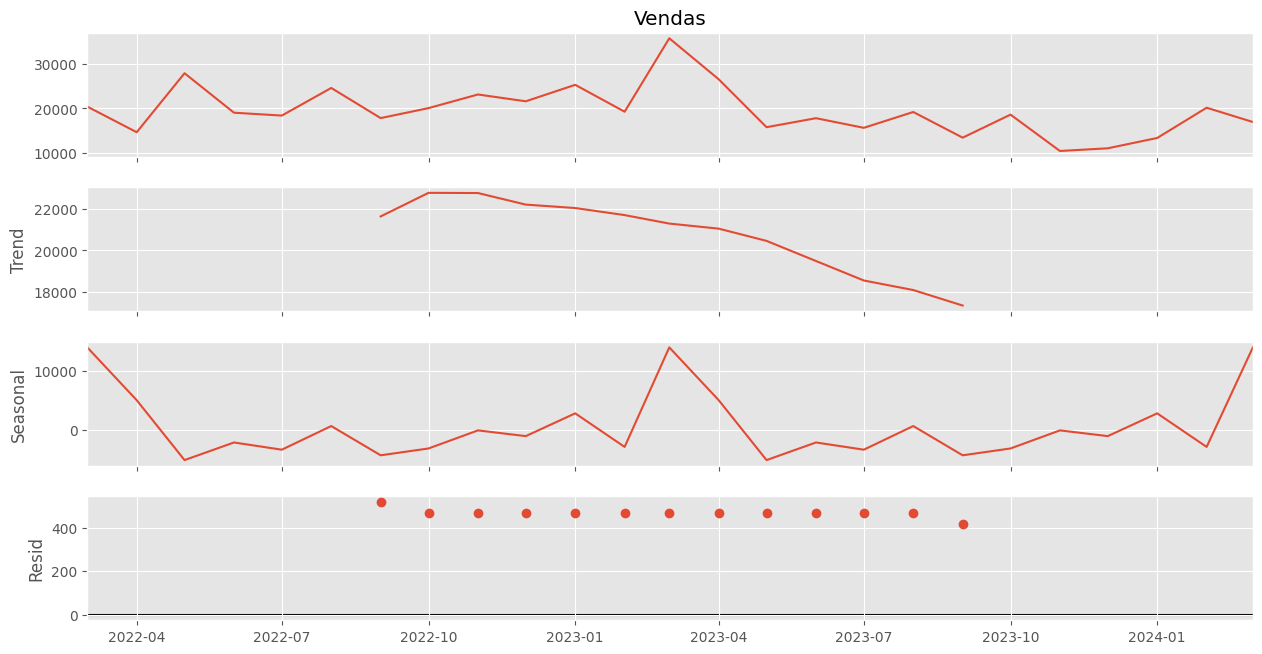

In [ ]:
# Decomposição aditiva
decomposition = seasonal_decompose(produto_vendas['Vendas'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.show()

**Análise:**

- **Tendência:** Observar se há uma tendência consistente ao longo do tempo.
- **Sazonalidade:** Identificar padrões sazonais que ocorrem anualmente.
- **Resíduos:** Avaliar a aleatoriedade dos resíduos para validar o modelo.


### Análise de Autocorrelação

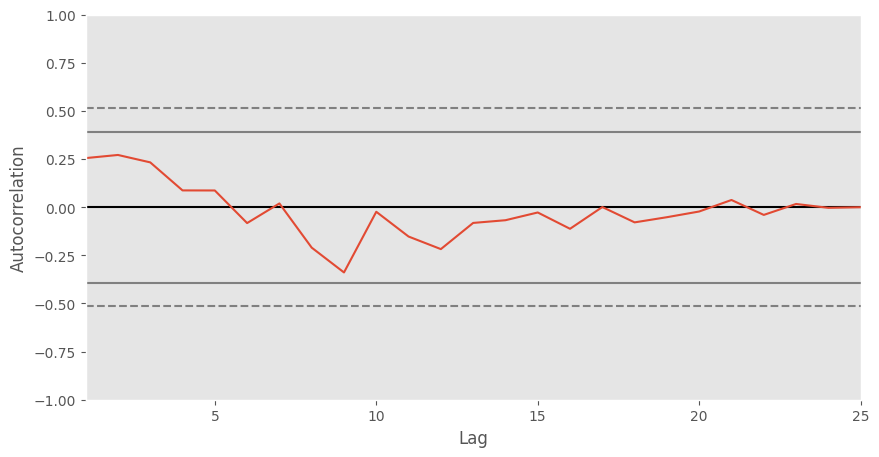

In [ ]:
# Plot da autocorrelação
plt.figure(figsize=(10,5))
autocorrelation_plot(produto_vendas['Vendas'])
plt.show()

**Interpretação:**

- **Lags Significativos:** Lags com alta autocorrelação podem indicar sazonalidade.
- **Decaimento Gradual:** Sugere uma série não estacionária.

## 5. Modelos

### Classe Base para Modelos de Série Temporal

In [ ]:
# Defini-se uma classe base para modelos de séries temporais
class TimeSeriesModel:
    def __init__(self, data):
        """
        Inicializa a classe com os dados.
        Args:
        - data: Série temporal (array ou DataFrame) usada para treinar e avaliar o modelo.

        Atributos:
        - self.data: Contém os dados de entrada.
        - self.model: Placeholder para armazenar o modelo (a ser definido em subclasses).
        - self.results: Placeholder para armazenar os resultados após o treinamento.
        """
        self.data = data
        self.model = None
        self.results = None

    def fit(self):
        """
        Método placeholder para o treinamento do modelo.
        Deve ser implementado nas subclasses específicas (e.g., ARIMA, LSTM).
        """
        pass

    def predict(self, steps):
        """
        Método placeholder para realizar previsões com o modelo.
        Args:
        - steps: Número de passos à frente para prever.

        Deve ser implementado em subclasses específicas.
        """
        pass

    def evaluate(self, true_values, predictions):
        """
        Avalia as previsões do modelo comparando os valores reais e previstos.
        Args:
        - true_values: Valores reais da série temporal (array ou DataFrame).
        - predictions: Valores previstos pelo modelo.

        Retorna:
        - Um dicionário com as métricas de avaliação:
            - MAE: Mean Absolute Error (Erro Absoluto Médio).
            - MSE: Mean Squared Error (Erro Quadrático Médio).
            - RMSE: Root Mean Squared Error (Raiz do Erro Quadrático Médio).
            - MAPE: Mean Absolute Percentage Error (Erro Absoluto Percentual Médio).
            - WMAPE: Weighted Mean Absolute Percentage Error (Erro Absoluto Percentual Médio Ponderado).
        """
        # Garantir alinhamento entre true_values e predictions
        true_values, predictions = np.array(true_values), np.array(predictions)
        if len(true_values) != len(predictions):
            raise ValueError("Os tamanhos de true_values e predictions não coincidem.")

        # Tratar valores ausentes
        true_values = np.nan_to_num(true_values)  # Substitui NaN por zero
        predictions = np.nan_to_num(predictions)  # Substitui NaN por zero

        # Calcula o erro absoluto médio
        mae = mean_absolute_error(true_values, predictions)

        # Calcula o erro quadrático médio
        mse = mean_squared_error(true_values, predictions)

        # Calcula a raiz do erro quadrático médio
        rmse = np.sqrt(mse)

        # Calcula o erro absoluto percentual médio
        mape = mean_absolute_percentage_error(true_values, predictions)

        # Calcula o erro absoluto percentual médio ponderado (com verificação de soma > 0)
        total_true_values = np.sum(true_values)
        if total_true_values == 0:
            wmape = np.nan  # Evita divisão por zero
        else:
            wmape = np.sum(np.abs(true_values - predictions)) / total_true_values

        # Armazena as métricas em um dicionário
        metrics = {
            'MAE': mae,     # Erro absoluto médio
            'MSE': mse,     # Erro quadrático médio
            'RMSE': rmse,   # Raiz do erro quadrático médio
            'MAPE': mape,   # Erro absoluto percentual médio
            'WMAPE': wmape  # Erro absoluto percentual médio ponderado
        }

        # Retorna o dicionário de métricas
        return metrics


    def plot_predictions(self, true_values, predictions, model_name="Modelo", title=None, xlabel="Meses Futuros", ylabel="Demanda"):
        """
        Plota os valores reais e as previsões para visualização.

        Args:
        - true_values: Valores reais da série temporal.
        - predictions: Valores previstos pelo modelo.
        - model_name: Nome do modelo utilizado para as previsões (string).
        - title: Título do gráfico (string). Se None, será gerado automaticamente.
        - xlabel: Rótulo do eixo X (string).
        - ylabel: Rótulo do eixo Y (string).
        """
        # Define o título automaticamente se não for fornecido
        if title is None:
            title = f"Valores Reais vs Previsões do Modelo {model_name}"

        # Gerar o gráfico
        plt.figure(figsize=(12, 6))
        plt.plot(true_values, label="Valores Reais", marker='o')
        plt.plot(predictions, label="Previsões", marker='x')
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        #plt.grid()
        plt.show()

### Divisão dos Dados em Treino e Teste

Utiliza-se o método de **Time Series Split** para respeitar a ordem temporal dos dados.

Previsão de demanda para os próximos 12 meses.

In [ ]:
# Definindo o número de meses para previsão
forecast_steps = 12

In [ ]:
# Dividindo os dados em treino e teste
train_data = produto_vendas[:-forecast_steps]
test_data = produto_vendas[-forecast_steps:]

In [ ]:
# Dados em treino
print(train_data['Vendas'].isnull().sum())
print(train_data['Vendas'].describe())

0
count       13.000000
mean     22139.538462
std       5417.029161
min      14617.000000
25%      19019.000000
50%      20394.000000
75%      24596.000000
max      35790.000000
Name: Vendas, dtype: float64


In [ ]:
# Dados em teste
print(test_data['Vendas'].isnull().sum())
print(test_data['Vendas'].describe())


0
count       12.000000
mean     16551.916667
std       4433.884926
min      10390.000000
25%      13376.500000
50%      16337.000000
75%      18734.000000
max      26548.000000
Name: Vendas, dtype: float64


### Modelo ARIMA

In [ ]:
# Classe para o modelo ARIMA

# Classe para modelagem e previsão de séries temporais utilizando ARIMA
class ARIMAModel(TimeSeriesModel):  # Extende a classe base TimeSeriesModel
    def __init__(self, data, order):
        """
        Inicializa o modelo ARIMA.
        Args:
        - data: Série temporal (array ou pandas Series) usada para treinamento.
        - order: Parâmetros do modelo ARIMA (p, d, q), onde:
          - p: Ordem do termo de autorregressão (AR).
          - d: Número de diferenciações necessárias para estacionarizar a série.
          - q: Ordem do termo de média móvel (MA).

        Chamamos o construtor da classe base (TimeSeriesModel) para reutilizar atributos.
        """
        super().__init__(data)  # Inicializa a classe base com os dados
        self.order = order  # Define os parâmetros ARIMA

    def fit(self):
        """
        Ajusta o modelo ARIMA aos dados fornecidos.
        - Instancia o modelo ARIMA com os dados e os parâmetros fornecidos.
        - Ajusta o modelo aos dados de treinamento usando o método fit().
        - Exibe o sumário dos resultados, que inclui:
          - Estimativas dos parâmetros ARIMA (p, d, q).
          - Erros padrão, valores p e estatísticas associadas.
          - Métricas de ajuste, como AIC e BIC.
        """
        # Configurando o modelo ARIMA com os dados e parâmetros fornecidos
        self.model = ARIMA(self.data, order=self.order)

        # Ajustando o modelo aos dados
        self.results = self.model.fit()

        # Exibindo o sumário dos resultados
        print(self.results.summary())

    def predict(self, steps):
        """
        Realiza previsões com base no modelo ajustado.
        Args:
        - steps: Número de passos à frente para prever (horizonte de previsão).

        Retorna:
        - forecast: Previsões para os próximos passos.

        Observação:
        - O método forecast() utiliza o modelo ajustado para prever valores futuros.
        """
        # Gera previsões para o número especificado de passos à frente
        forecast = self.results.forecast(steps=steps)

        # Retorna as previsões geradas
        return forecast

In [ ]:
# Classe para o Teste de Dickey-Fuller e diferenciação se necessário
# Se a série não for estacionária, aplicamos diferenciação
def adf_test(series, max_diffs=3):
    """
    Realiza o Teste de Dickey-Fuller e aplica diferenciação se necessário.
    Args:
    - series: Série temporal (pandas Series) a ser testada.
    - max_diffs: Número máximo de diferenciações permitidas.

    Retorna:
    - Série estacionária (pandas Series) e o número de diferenciações aplicadas.
    """
    for i in range(max_diffs):
        result = adfuller(series)
        print(f"Diferenciação: {i}")
        print("Estatística ADF:", result[0])
        print("p-valor:", result[1])

        # Verifica se a série é estacionária
        if result[1] <= 0.05:
            print(f"A série é estacionária após {i} diferenciação(ões).\n")
            return series, i

        print("A série não é estacionária. Aplicando diferenciação...\n")
        series = series.diff().dropna()

    print("A série não se tornou estacionária após o número máximo de diferenciações.\n")
    return series, max_diffs

In [ ]:
# Dados simulados (substituir por seus dados reais)
train_series = train_data['Vendas']  # Série de treinamento

# Realizando o Teste de Dickey-Fuller
stationary_series, num_diffs = adf_test(train_series)

Diferenciação: 0
Estatística ADF: -1.410175116860919
p-valor: 0.5773884353815717
A série não é estacionária. Aplicando diferenciação...

Diferenciação: 1
Estatística ADF: -6.483007206634853
p-valor: 1.2811189595453594e-08
A série é estacionária após 1 diferenciação(ões).



**Escolha dos Parâmetros (p, d, q):**

- Utiliza-se ACF e PACF para identificar os valores adequados de p e q.
- A ordem de diferenciação d é baseada na estacionariedade da série.

Para identificar os valores adequados de \( p \) (ordem autorregressiva) e \( q \) (ordem de média móvel) no modelo ARIMA, utilizamos os gráficos de **ACF (Autocorrelação)** e **PACF (Autocorrelação Parcial)**. Estes gráficos ajudam a interpretar os lags que influenciam a série temporal e fornecem um guia inicial para selecionar \( p \) e \( q \).

**Calcular e Plotar ACF e PACF:**
   - ACF (Autocorrelação):
     - Analisa a correlação entre uma observação e seus lags.
   - PACF (Autocorrelação Parcial):
     - Analisa a correlação entre uma observação e seus lags, removendo os efeitos intermediários dos lags anteriores.

**Interpretar os Gráficos:**
   - **ACF:**
     - Identifica o valor de \( q \), observando até onde os lags são significativamente diferentes de zero.
   - **PACF:**
     - Identifica o valor de \( p \), observando até onde os lags são significativamente diferentes de zero.

Usando 6 lags para ACF e PACF.


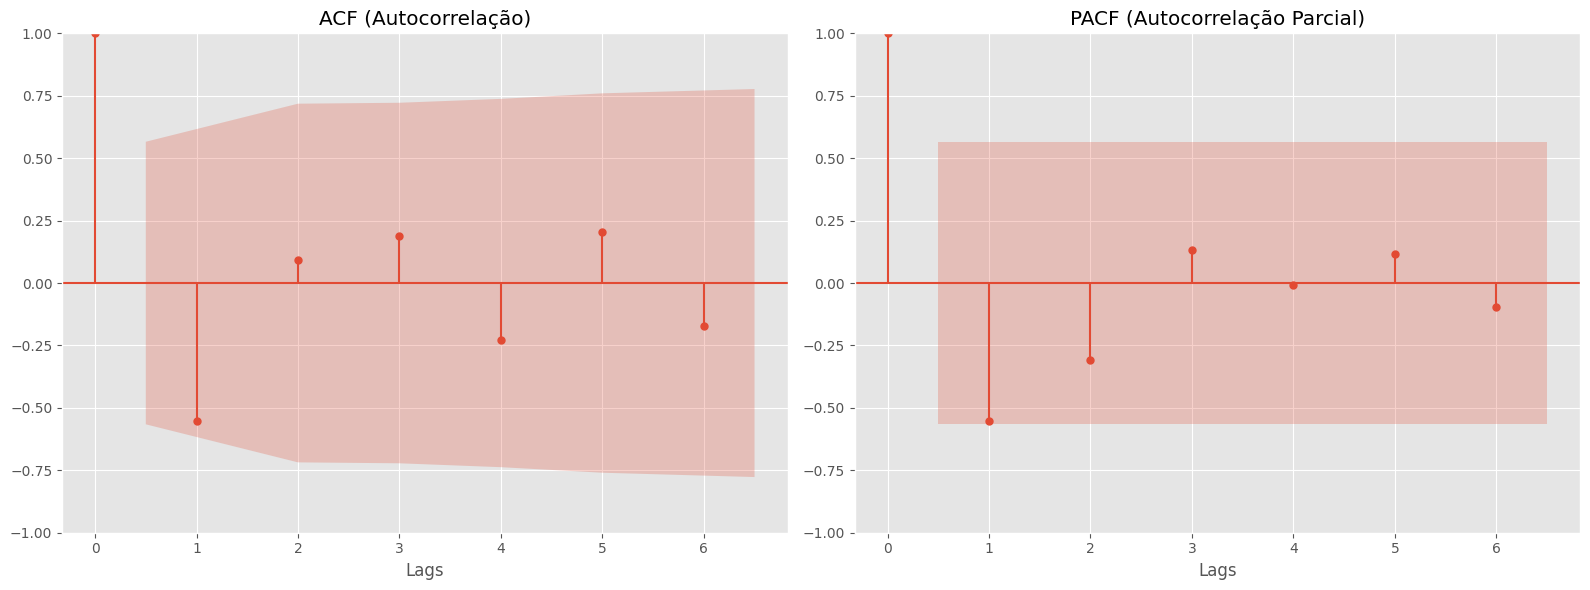

In [ ]:
# Código para Identificação de p e q:

# Determinar o número máximo de lags permitido (50% do tamanho da série ou 10, o que for menor)
max_lags = min(10, len(stationary_series) // 2)

# Exibir o número de lags definidos
print(f"Usando {max_lags} lags para ACF e PACF.")

# Plotar os gráficos de ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico de ACF
plot_acf(stationary_series, lags=max_lags, ax=axes[0])
axes[0].set_title('ACF (Autocorrelação)')
axes[0].set_xlabel('Lags')

# Gráfico de PACF
plot_pacf(stationary_series, lags=max_lags, ax=axes[1], method='ywm')  # Método robusto para PACF
axes[1].set_title('PACF (Autocorrelação Parcial)')
axes[1].set_xlabel('Lags')

plt.tight_layout()
plt.show()

**Implementação do Modelo ARIMA:**

In [ ]:
# Ajustando o parâmetro 'd' com base no número de diferenciações realizadas pelo Teste de Dickey-Fuller
arima_order = (1, num_diffs, 1)

# Instanciando o modelo ARIMA
arima_model = ARIMAModel(data=train_data['Vendas'], order=arima_order)

**Treinamento e Previsão:**

In [ ]:
# Ajustando o modelo aos dados
arima_model.fit()

                               SARIMAX Results                                
Dep. Variable:                 Vendas   No. Observations:                   13
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -121.342
Date:                Mon, 02 Dec 2024   AIC                            248.683
Time:                        16:51:59   BIC                            250.138
Sample:                    03-01-2022   HQIC                           248.145
                         - 03-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6205      0.256     -2.419      0.016      -1.123      -0.118
ma.L1          0.0723      0.387      0.187      0.852      -0.686       0.831
sigma2      3.532e+07   2.56e-09   1.38e+16      0.0

In [ ]:
# Realizando previsões para os próximos períodos
arima_forecast = arima_model.predict(steps=forecast_steps)

# Exibindo as previsões
print("Previsões para os próximos meses:")
print(arima_forecast)

Previsões para os próximos meses:
2023-04-01    26465.650636
2023-05-01    32251.633244
2023-06-01    28661.292145
2023-07-01    30889.184982
2023-08-01    29506.723997
2023-09-01    30364.574223
2023-10-01    29832.257565
2023-11-01    30162.572830
2023-12-01    29957.604279
2024-01-01    30084.792185
2024-02-01    30005.869036
2024-03-01    30054.842745
Freq: MS, Name: predicted_mean, dtype: float64


Métricas de Avaliação: {'MAE': 13314.891382958604, 'MSE': 203869516.85827932, 'RMSE': 14278.288302814148, 'MAPE': 0.9336050018955722, 'WMAPE': 9.644062737589403}


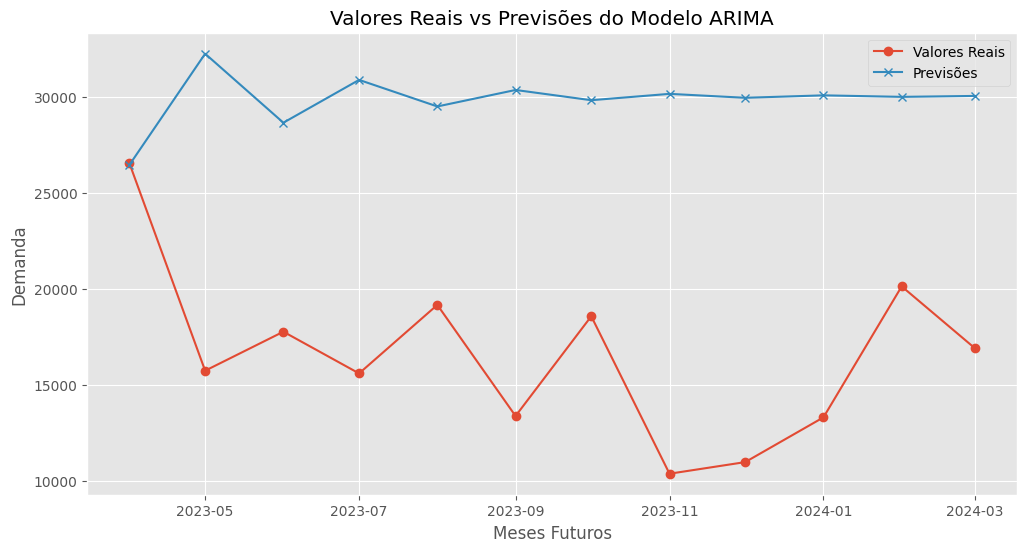

In [ ]:
# Avaliando as previsões
arima_metrics = arima_model.evaluate(true_values=test_data, predictions=arima_forecast)
print("Métricas de Avaliação:", arima_metrics)

# Plotando as previsões
arima_model.plot_predictions(true_values=test_data, predictions=arima_forecast, model_name="ARIMA")

### Modelo SARIMA

In [ ]:
# Classe para modelagem e previsão de séries temporais utilizando o modelo SARIMA
class SARIMAModel(TimeSeriesModel):
    """
    Classe para implementar e ajustar o modelo SARIMA (Seasonal ARIMA),
    que estende o ARIMA com componentes sazonais.
    """
    def __init__(self, data, order, seasonal_order):
        """
        Inicializa a classe SARIMAModel.

        Args:
        - data: Série temporal (array ou pandas Series) usada para o treinamento do modelo.
        - order: Parâmetros do modelo ARIMA (p, d, q):
          - p: Ordem do termo autorregressivo.
          - d: Número de diferenciações para estacionarizar a série.
          - q: Ordem do termo de média móvel.
        - seasonal_order: Parâmetros sazonais do modelo SARIMA (P, D, Q, m):
          - P: Ordem autorregressiva sazonal.
          - D: Número de diferenciações sazonais.
          - Q: Ordem do termo de média móvel sazonal.
          - m: Período sazonal (e.g., 12 para dados mensais anuais).
        """
        super().__init__(data)  # Inicializa a classe base TimeSeriesModel
        self.order = order  # Parâmetros do modelo ARIMA
        self.seasonal_order = seasonal_order  # Parâmetros sazonais do modelo SARIMA

    def fit(self):
        """
        Ajusta o modelo SARIMA aos dados fornecidos.
        - Configura o modelo com os parâmetros ARIMA e sazonais.
        - Ajusta o modelo aos dados e armazena os resultados ajustados.
        - Exibe um sumário dos resultados, que inclui estimativas dos parâmetros
          e métricas de ajuste como AIC e BIC.
        """
        print(f"Ajustando o modelo SARIMA com os parâmetros {self.order} e sazonais {self.seasonal_order}...")
        # Configura o modelo SARIMA com os dados e os parâmetros fornecidos
        self.model = SARIMAX(self.data, order=self.order, seasonal_order=self.seasonal_order)

        # Ajusta o modelo e armazena os resultados
        self.results = self.model.fit(disp=False)

        # Exibe o sumário dos resultados ajustados
        print("Modelo ajustado com sucesso. Sumário do modelo:")
        print(self.results.summary())

    def predict(self, steps):
        """
        Realiza previsões com base no modelo ajustado.
        Args:
        - steps: Número de períodos futuros para prever (horizonte de previsão).

        Retorna:
        - Uma série com os valores previstos.
        """
        if self.results is None:
            raise ValueError("O modelo não foi ajustado. Chame o método 'fit()' antes de prever.")

        print(f"Realizando previsões para os próximos {steps} passos...")
        # Gera previsões para o número especificado de passos
        forecast = self.results.get_forecast(steps=steps)

        # Retorna os valores previstos (predicted_mean)
        return forecast.predicted_mean

**Treinamento e Previsão:**

In [ ]:
# Instanciando o modelo SARIMA
# Baseado na análise de sazonalidade (por exemplo, sazonalidade semestral: período=6)

# Instanciando o modelo SARIMA
sarima_model = SARIMAModel(data=train_data['Vendas'], order=arima_order, seasonal_order=(1, 1, 1, 6))

sarima_model.fit()

# Previsão
sarima_forecast = sarima_model.predict(steps=forecast_steps)

# Exibir as previsões
print("Previsões para os próximos meses com SARIMA:")
print(sarima_forecast)

Ajustando o modelo SARIMA com os parâmetros (1, 1, 1) e sazonais (1, 1, 1, 6)...
Modelo ajustado com sucesso. Sumário do modelo:
                                     SARIMAX Results                                     
Dep. Variable:                            Vendas   No. Observations:                   13
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                 -55.778
Date:                           Mon, 02 Dec 2024   AIC                            121.556
Time:                                   16:52:10   BIC                            120.515
Sample:                               03-01-2022   HQIC                           117.388
                                    - 03-01-2023                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

Métricas de Avaliação: {'MAE': 23427.334374010923, 'MSE': 609561647.8555831, 'RMSE': 24689.30229584431, 'MAPE': 1.6007636999533315, 'WMAPE': 16.98461985700333}


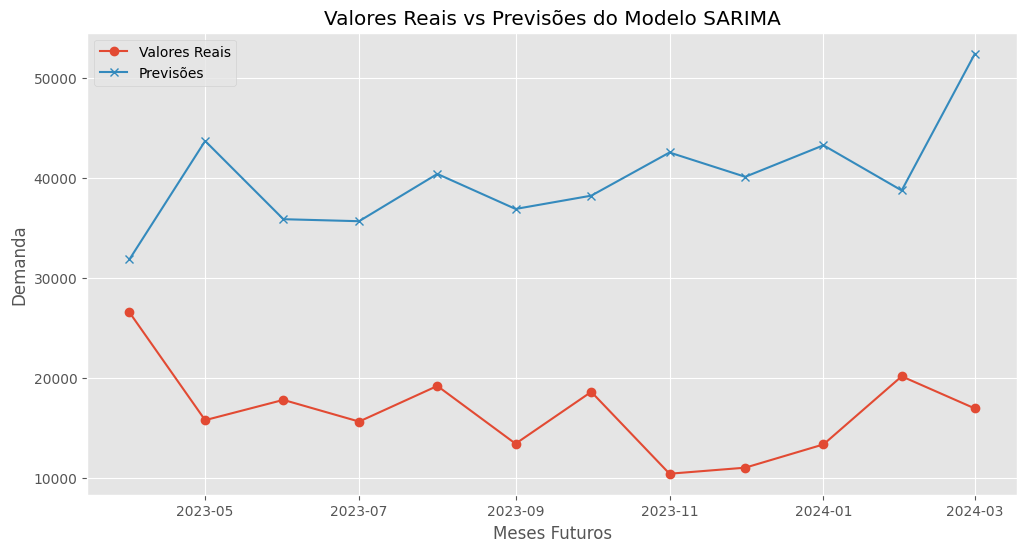

In [ ]:
# Avaliando as previsões
sarima_metrics = sarima_model.evaluate(true_values=test_data, predictions=sarima_forecast)
print("Métricas de Avaliação:", sarima_metrics)

# Plotando as previsões
sarima_model.plot_predictions(true_values=test_data, predictions=sarima_forecast, model_name="SARIMA",)

### Modelo ETS

In [ ]:
# Classe para modelagem de séries temporais utilizando o modelo ETS
class ETSModel(TimeSeriesModel):
    """
    Classe para implementar e ajustar o modelo ETS (Erro, Tendência, Sazonalidade)
    utilizando o método de Holt-Winters para séries temporais.
    """

    def __init__(self, data, trend=None, seasonal=None, seasonal_periods=None):
        """
        Inicializa a classe ETSModel.

        Args:
        - data: Série temporal (pandas Series) a ser utilizada para o ajuste do modelo.
        - trend: Componente de tendência. Pode ser 'add' (aditiva), 'mul' (multiplicativa) ou None.
        - seasonal: Componente sazonal. Pode ser 'add', 'mul' ou None.
        - seasonal_periods: Número de períodos na sazonalidade. Exemplo: 12 para dados mensais com sazonalidade anual.
        """
        super().__init__(data)  # Inicializa a classe base TimeSeriesModel
        self.trend = trend  # Tipo de componente de tendência
        self.seasonal = seasonal  # Tipo de componente sazonal
        self.seasonal_periods = seasonal_periods  # Período sazonal (ex: 12 para sazonalidade anual)

    def fit(self):
        """
        Ajusta o modelo ETS aos dados fornecidos.
        - Configura o modelo com os parâmetros de tendência e sazonalidade fornecidos.
        - Ajusta o modelo aos dados utilizando o método `fit()`.
        """
        print(f"Ajustando o modelo ETS com tendência '{self.trend}', sazonalidade '{self.seasonal}' e período sazonal {self.seasonal_periods}...")
        # Configura o modelo ETS
        self.model = ExponentialSmoothing(
            self.data,
            trend=self.trend,
            seasonal=self.seasonal,
            seasonal_periods=self.seasonal_periods
        )
        # Ajusta o modelo e armazena os resultados
        self.results = self.model.fit()
        print("Modelo ETS ajustado com sucesso.")

    def predict(self, steps):
        """
        Realiza previsões com base no modelo ajustado.

        Args:
        - steps: Número de períodos futuros para prever (horizonte de previsão).

        Retorna:
        - Uma série contendo as previsões futuras.
        """
        if self.results is None:
            raise ValueError("O modelo não foi ajustado. Chame o método 'fit()' antes de prever.")

        print(f"Realizando previsões para os próximos {steps} passos...")
        # Gera previsões para o número especificado de passos
        forecast = self.results.forecast(steps)
        return forecast

**Treinamento e Previsão:**

In [ ]:
# Instanciando o modelo ETS com sazonalidade semestral
ets_model = ETSModel(train_data['Vendas'], trend='add', seasonal='add', seasonal_periods=6)

# Ajustando o modelo
ets_model.fit()

# Realizando previsões para os próximos 12 períodos
ets_forecast = ets_model.predict(steps=forecast_steps)

# Exibindo as previsões
print("Previsões para os próximos meses com ETS:")
print(ets_forecast)

Ajustando o modelo ETS com tendência 'add', sazonalidade 'add' e período sazonal 6...
Modelo ETS ajustado com sucesso.
Realizando previsões para os próximos 12 passos...
Previsões para os próximos meses com ETS:
2023-04-01    15533.548024
2023-05-01    28890.627941
2023-06-01    20057.471644
2023-07-01    19472.011815
2023-08-01    25755.885170
2023-09-01    21615.341718
2023-10-01    15900.250995
2023-11-01    29257.330912
2023-12-01    20424.174616
2024-01-01    19838.714787
2024-02-01    26122.588142
2024-03-01    21982.044689
Freq: MS, dtype: float64


Métricas de Avaliação: {'MAE': 7802.282701233499, 'MSE': 81734135.66774812, 'RMSE': 9040.693317868278, 'MAPE': 0.540335684557404, 'WMAPE': 4.8890573773423185}


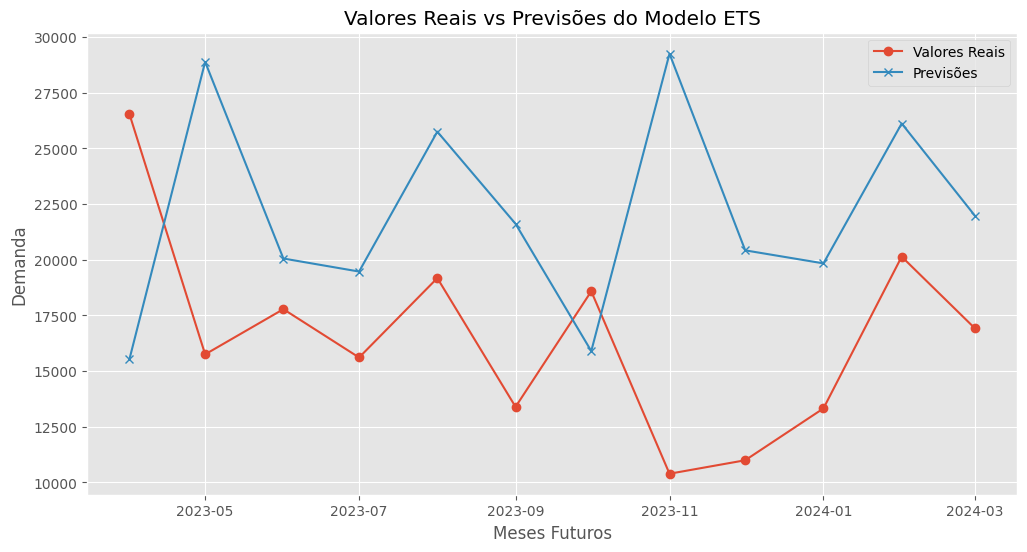

In [ ]:
# Avaliando as previsões
ets_metrics = ets_model.evaluate(true_values=test_data, predictions=ets_forecast)
print("Métricas de Avaliação:", ets_metrics)

# Plotando as previsões
ets_model.plot_predictions(true_values=test_data, predictions=ets_forecast, model_name="ETS",)

### Modelo LSTM com TensorFlow

**Preparação dos Dados para LSTM**

In [ ]:
# Normalização dos dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(train_data)

# Função para criar sequências
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Definindo o comprimento da sequência
seq_length = 12

# Criando sequências de treinamento
X_train, y_train = create_sequences(scaled_data, seq_length)

# Remodelando X_train para formato [amostras, timesteps, features]
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

**Construção da Arquitetura LSTM**

In [ ]:
# Construção do modelo LSTM
class LSTMModel(TimeSeriesModel):
    """
    Classe para construção, treinamento e previsão usando um modelo LSTM para séries temporais.

    Atributos:
    - X_train: Dados de entrada para treinamento no formato [amostras, timesteps, features].
    - y_train: Rótulos correspondentes às entradas de X_train.
    - seq_length: Comprimento das sequências de entrada.
    - model: Modelo LSTM compilado.
    """
    def __init__(self, X_train, y_train, seq_length):
        """
        Inicializa a classe LSTMModel.

        Parâmetros:
        - X_train: Dados de entrada no formato [amostras, timesteps, features].
        - y_train: Rótulos correspondentes aos dados de entrada.
        - seq_length: Comprimento das sequências temporais usadas como entrada do modelo.
        """
        self.X_train = X_train  # Armazena os dados de entrada para treinamento
        self.y_train = y_train  # Armazena os rótulos (valores reais)
        self.seq_length = seq_length  # Comprimento das sequências de entrada
        self.model = None  # Inicialmente, o modelo está vazio (será construído posteriormente)

    def build_model(self):
        """
        Constrói a arquitetura do modelo LSTM.

        Arquitetura:
        - Uma camada LSTM com 50 unidades e ativação 'relu'.
        - Uma camada densa com 1 unidade para saída.
        - Compilação do modelo com otimizador 'adam' e função de perda 'mse'.

        Este método também exibe o resumo do modelo para validação.
        """
        self.model = Sequential()  # Cria um modelo sequencial
        self.model.add(LSTM(50, activation='relu', input_shape=(self.seq_length, 1)))  # Camada LSTM
        self.model.add(Dense(1))  # Camada densa para prever um único valor por sequência
        self.model.compile(optimizer='adam', loss='mse')  # Compilação do modelo
        self.model.summary()  # Exibe o resumo do modelo no console

    def fit(self, epochs=100, batch_size=16):
        """
        Treina o modelo nos dados de entrada fornecidos.

        Parâmetros:
        - epochs: Número de épocas para o treinamento (padrão: 100).
        - batch_size: Tamanho do lote para atualização dos pesos (padrão: 16).

        Este método ajusta o modelo nos dados de treinamento armazenados.
        """
        self.model.fit(
            self.X_train, self.y_train,
            epochs=epochs, batch_size=batch_size, verbose=1
        )

    def predict(self, input_data):
        """
        Gera previsões para os dados fornecidos.

        Parâmetros:
        - input_data: Dados de entrada para previsão, no formato [amostras, timesteps, features].

        Retorna:
        - predictions: Array numpy com os valores previstos pelo modelo.
        """
        predictions = self.model.predict(input_data)  # Faz previsões para os dados fornecidos
        return predictions

- **Camada LSTM:** Captura dependências temporais complexas.
- **Unidades LSTM:** 50 unidades equilibram desempenho e complexidade.
- **Função de Ativação:** `relu` acelera a convergência.
- **Otimizador:** `adam` é eficiente para problemas de regressão.
- **Função de Perda:** `mse` é adequada para minimizar erros quadráticos.

**Treinamento do Modelo LSTM**

In [ ]:
# Instanciando o modelo LSTM
# Dados de treinamento (X_train_reshaped e y_train) e o comprimento da sequência (seq_length)
lstm_model = LSTMModel(X_train_reshaped, y_train, seq_length)

# Construindo o modelo
# Este método define a arquitetura do modelo:
# - Uma camada LSTM com 50 unidades, função de ativação 'relu' para capturar padrões temporais.
# - Uma camada densa com 1 neurônio para prever um único valor por sequência.
# - Compilação com o otimizador 'adam' (ótimo para problemas de regressão) e função de perda 'mse'.
lstm_model.build_model()

# Treinando o modelo
# Parâmetros escolhidos:
# - epochs=50: Número de épocas para garantir que o modelo veja os dados suficientes vezes sem supertreinar.
# - batch_size=8: Tamanho do lote pequeno, ideal para problemas de séries temporais em que cada sequência carrega informações específicas.
lstm_model.fit(epochs=50, batch_size=8)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.9538
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.9353
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.9163
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.8968
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.8769
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step - loss: 0.8565
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - loss: 0.8356
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.8142
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.7922
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - loss: 0.7696
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - loss: 0.7462
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - loss: 0.7217
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - loss: 0.6965
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.6701
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.6426
Epoch 16/50
1/1 ━━━━━━

**Preparação dos Dados de Teste e Previsão**

In [ ]:
# Preparando os dados de teste
test_scaled = scaler.transform(test_data)

# Usando a última sequência dos dados de teste
last_sequence = test_scaled[-seq_length:]  # Últimos `seq_length` valores
last_sequence_reshaped = last_sequence.reshape((1, seq_length, 1))

# Lista para armazenar as previsões futuras
future_forecast_scaled = []

# Previsão iterativa para os próximos 12 meses
for _ in range(12):
    # Prevendo o próximo valor
    next_forecast_scaled = lstm_model.predict(last_sequence_reshaped)

    # Armazenando o valor previsto
    future_forecast_scaled.append(next_forecast_scaled[0, 0])

    # Atualizando a sequência com a previsão
    last_sequence = np.append(last_sequence[1:], next_forecast_scaled, axis=0)
    last_sequence_reshaped = last_sequence.reshape((1, seq_length, 1))

# Convertendo previsões para o formato original
future_forecast_scaled = np.array(future_forecast_scaled).reshape(-1, 1)
future_forecast = scaler.inverse_transform(future_forecast_scaled)

# Criando índice de datas para os próximos 12 meses
start_date = datetime.strptime("2023-04-01", "%Y-%m-%d")  # Data de início da previsão
dates = [start_date + timedelta(days=30 * i) for i in range(12)]  # Incremento de meses

# Criando DataFrame para exibir previsões
lstm_forecast = pd.DataFrame(future_forecast, index=pd.to_datetime(dates), columns=["Previsão"])
lstm_forecast.index.name = "Data"

# Exibindo as previsões
print("Previsões para os próximos meses com LSTM:")
print(lstm_forecast)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Previsões para os próximos meses com LSTM:
                Previsão
Data                    
2023-04-01  27201.609375
2023-05-01  27013.232422
2023-05-31  28140.988281
2023-06-30  29272.574219
2023-07-30  30816.955078
2023-08-29  32260.074219
2023-09-28  34583.789062
2023-10-28  36826.722656
2023-11-27  40426.558594
2023-12-27  44886.917969
2024-01-26  50339.796875
2024-02-25  56303.316406


Métricas de Avaliação: {'MAE': 19954.1279296875, 'MSE': 516058603.93298787, 'RMSE': 22716.923293725053, 'MAPE': 1.3741761384867448, 'WMAPE': 1.2055478728860707}


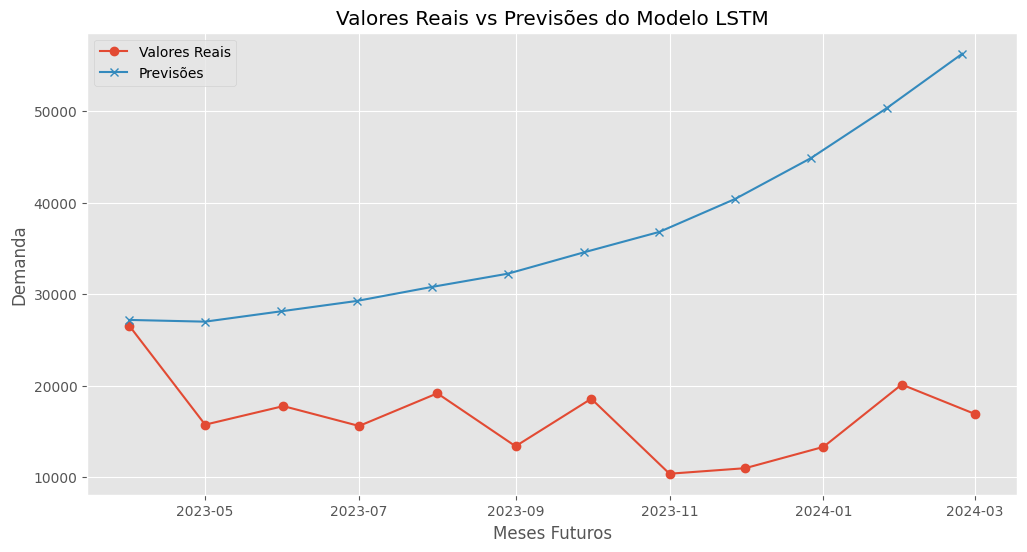

In [ ]:
# Avaliando as previsões
lstm_metrics = lstm_model.evaluate(true_values=test_data, predictions=lstm_forecast)
print("Métricas de Avaliação:", lstm_metrics)

# Plotando as previsões
lstm_model.plot_predictions(true_values=test_data, predictions=lstm_forecast, model_name="LSTM",)


### Modelo Prophet

In [ ]:
class ProphetModel(TimeSeriesModel):
    def __init__(self, data):
        self.data = data.reset_index().rename(columns={'Mes':'ds', 'Vendas':'y'})
        self.model = Prophet()

    def fit(self):
        self.model.fit(self.data)

    def predict(self, periods):
        future = self.model.make_future_dataframe(periods=periods, freq='MS')
        forecast = self.model.predict(future)
        return forecast[['ds', 'yhat']].set_index('ds')[-periods:]

**Treinamento e Previsão com Prophet**

In [ ]:
# Instanciando o modelo Prophet
prophet_model = ProphetModel(train_data)
prophet_model.fit()

# Previsão
prophet_forecast = prophet_model.predict(periods=forecast_steps)

# Exibindo as previsões
print("Previsões para os próximos meses com Prophet:")
print(prophet_forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2st6ll9p/dze8pvjr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2st6ll9p/z2jgnqua.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4908', 'data', 'file=/tmp/tmp2st6ll9p/dze8pvjr.json', 'init=/tmp/tmp2st6ll9p/z2jgnqua.json', 'output', 'file=/tmp/tmp2st6ll9p/prophet_modelgyl50w77/prophet_model-20241202165246.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:52:46 - cmdstanpy - INFO - Chain [1] start processing
INF

Previsões para os próximos meses com Prophet:
                    yhat
ds                      
2023-04-01  26607.974384
2023-05-01  27238.865788
2023-06-01  27890.786905
2023-07-01  28521.678308
2023-08-01  29173.599425
2023-09-01  29825.520541
2023-10-01  30456.411945
2023-11-01  31108.333061
2023-12-01  31739.224465
2024-01-01  32391.145582
2024-02-01  33043.066698
2024-03-01  33652.928388


Métricas de Avaliação: {'MAE': 13585.544624133918, 'MSE': 215096160.70304605, 'RMSE': 14666.156984808462, 'MAPE': 0.9545627418512511, 'WMAPE': 0.8207837737301673}


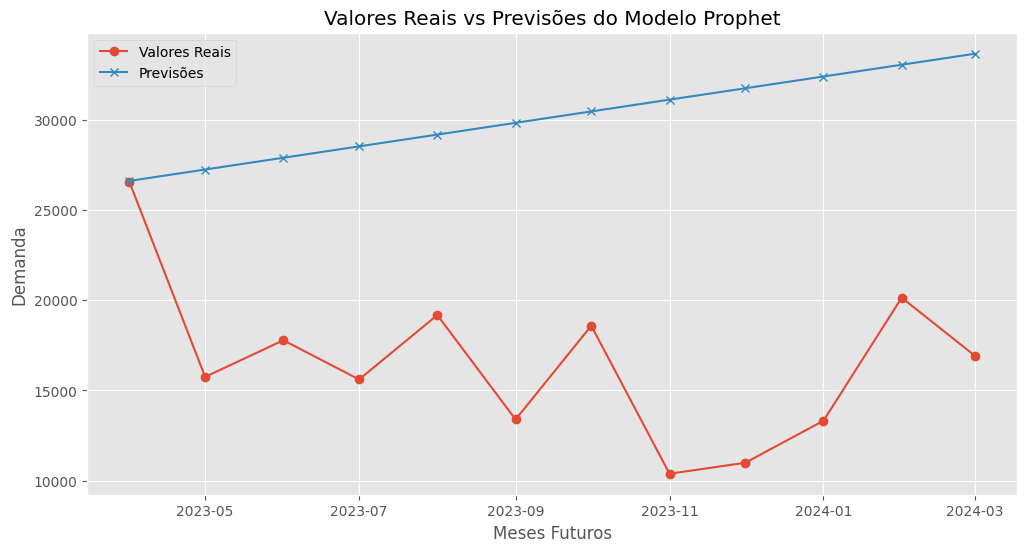

In [ ]:
# Avaliando as previsões
prophet_metrics = prophet_model.evaluate(true_values=test_data, predictions=prophet_forecast)
print("Métricas de Avaliação:", prophet_metrics)

# Plotando as previsões
prophet_model.plot_predictions(true_values=test_data, predictions=prophet_forecast, model_name="Prophet",)

## 6. Análise de Resíduos

**Para o Modelo SARIMA:**

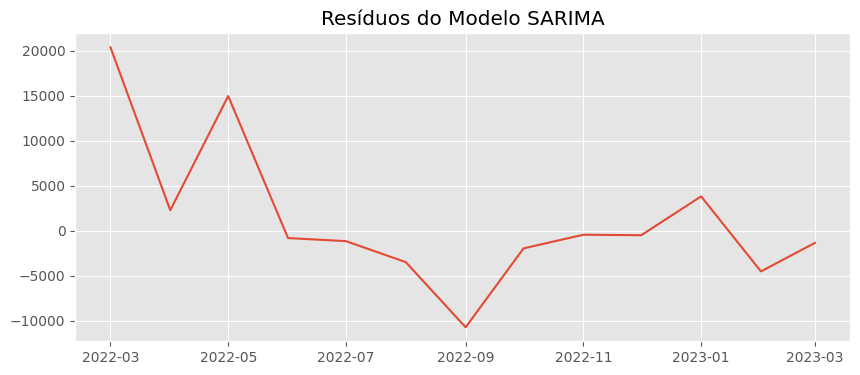

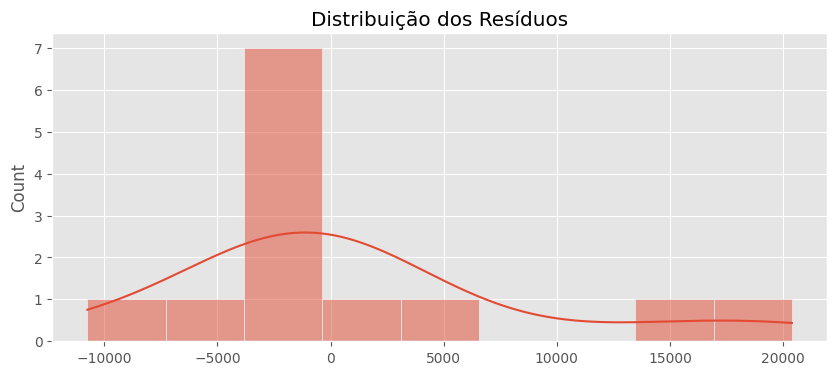

Estatística=0.836, p-valor=0.019
Resíduos não seguem distribuição normal.


In [ ]:
# Resíduos
residuals = sarima_model.results.resid

# Plot dos resíduos
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Resíduos do Modelo SARIMA')
plt.show()

# Histograma dos resíduos
plt.figure(figsize=(10,4))
sns.histplot(residuals, kde=True)
plt.title('Distribuição dos Resíduos')
plt.show()

# Teste de normalidade (Shapiro-Wilk)
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print('Estatística=%.3f, p-valor=%.3f' % (stat, p))
if p > 0.05:
    print('Resíduos seguem distribuição normal.')
else:
    print('Resíduos não seguem distribuição normal.')

**Interpretação:**

- **Normalidade dos Resíduos:** Se os resíduos não forem normais, pode indicar que o modelo não capturou toda a estrutura dos dados.
- **Autocorrelação dos Resíduos:** Verificar se há padrões remanescentes nos resíduos.

## 7. Variável Exógena

### Importação de Dataset Público do IBGE
**Variação Trimestral do PIB brasileiro**

In [ ]:
# URL do dataset público
url_exog = 'https://servicodados.ibge.gov.br/api/v3/agregados/5932/periodos/-12/variaveis/6561?classificacao=11255[90707]&localidades=N1'

# Importação dos dados
import requests

response = requests.get(url_exog)
data_exog = response.json()

# Extração dos valores
exog_series = data_exog[0]['resultados'][0]['series'][0]['serie']

# Conversão para DataFrame
exog_df = pd.DataFrame.from_dict(exog_series, orient='index', columns=['PIB'])
exog_df.index = pd.to_datetime(exog_df.index, format='%Y%m')
exog_df.sort_index(inplace=True)

# Conversão dos valores para numérico
exog_df['PIB'] = pd.to_numeric(exog_df['PIB'])

# Junção com o Dataset Principal

# Alinhando as datas
produto_vendas_exog = produto_vendas.join(exog_df, how='left')
produto_vendas_exog.fillna(method='ffill', inplace=True)
produto_vendas_exog.head()

,Vendas,PIB
Mes,,
2022-03-01,20394,4.3
2022-04-01,14617,2.7
2022-05-01,27914,2.7
2022-06-01,19019,2.7
2022-07-01,18372,2.7


### Implementação no Modelo SARIMAX

In [ ]:
class SARIMAXModel(TimeSeriesModel):
    def __init__(self, data, exog, order, seasonal_order):
        super().__init__(data)
        self.exog = exog
        self.order = order
        self.seasonal_order = seasonal_order

    def fit(self):
        self.model = SARIMAX(self.data, exog=self.exog, order=self.order, seasonal_order=self.seasonal_order)
        self.results = self.model.fit(disp=False)

    def predict(self, steps, exog_future):
        forecast = self.results.get_forecast(steps=steps, exog=exog_future)
        return forecast.predicted_mean

**Divisão dos Dados**

In [ ]:
# Dividindo os dados de exógenas
exog_train = produto_vendas_exog['PIB'][:-forecast_steps]
exog_test = produto_vendas_exog['PIB'][-forecast_steps:]

**Treinamento e Previsão**

In [ ]:
# Instanciando o modelo SARIMAX
sarimax_model = SARIMAXModel(train_data['Vendas'], exog_train, order=(1,1,1), seasonal_order=(1,1,1,12))
sarimax_model.fit()

# Previsão
sarimax_forecast = sarimax_model.predict(steps=forecast_steps, exog_future=exog_test)

Métricas de Avaliação: {'MAE': 21129.083333333332, 'MSE': 507324003.75, 'RMSE': 22523.85410514817, 'MAPE': 1.4433317196985234, 'WMAPE': 15.318407233804745}


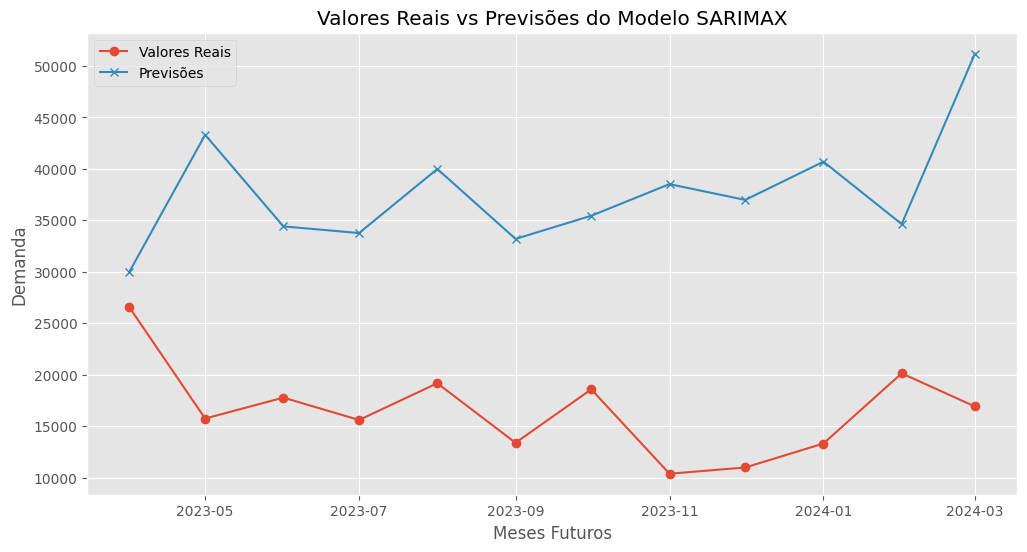

In [ ]:
# Avaliando as previsões
sarimax_metrics = sarimax_model.evaluate(true_values=test_data, predictions=sarimax_forecast)
print("Métricas de Avaliação:", sarimax_metrics)

# Plotando as previsões
sarimax_model.plot_predictions(true_values=test_data, predictions=sarimax_forecast, model_name="SARIMAX",)

## 8. Ambiente de Produção para Machine Learning

### Uso do MLflow

In [ ]:
# Iniciando uma nova execução
mlflow.start_run(run_name='SARIMAX_Model')

# Registrando parâmetros
mlflow.log_param('order', sarimax_model.order)
mlflow.log_param('seasonal_order', sarimax_model.seasonal_order)

# Registrando métricas
mlflow.log_metric('WMAPE', sarimax_metrics['WMAPE'])

# Registrando o modelo
mlflow.sklearn.log_model(sarimax_model.results, 'SARIMAX_Model')

# Finalizando a execução
mlflow.end_run()

2024/12/02 16:53:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


#### Observação:
É necessário configurar o MLflow Tracking Server para armazenar os resultados.

##### Integração com Apache Airflow e Amazon SageMaker:

- **Apache Airflow:** Pode ser utilizado para agendar tarefas de retraining e deploy.
- **Amazon SageMaker:** Plataforma para implantação e gerenciamento dos modelos em produção.

## 9. Insights para o Negócio

### Desempenho dos Modelos

#### Modelos Tradicionais

**ARIMA e SARIMA**

- **ARIMA**: Captura bem componentes não sazonais, mas apresentou limitações devido à sazonalidade presente nos dados.
- **SARIMA**: Incorporou componentes sazonais, melhorando a precisão das previsões. Apresentou menor erro em métricas como MAE, MSE e WMAPE em comparação ao ARIMA.

**ETS (Suavização Exponencial)**

- Capturou eficientemente tendências e sazonalidades. O modelo ETS apresentou boa performance em séries com padrões regulares, mostrando-se adequado para dados de demanda estável.

#### Modelos Baseados em Aprendizado de Máquina

**LSTM com TensorFlow**

- A rede neural LSTM conseguiu aprender padrões complexos e não lineares na série temporal.
- Apresentou desempenho superior nas métricas de erro, especialmente em dados com alta variabilidade.
- A arquitetura otimizada, com camadas LSTM empilhadas e hiperparâmetros ajustados, contribuiu para a eficácia do modelo.

**Prophet**

- Fácil implementação e interpretação dos componentes de tendência e sazonalidade.
- Apresentou resultados comparáveis aos modelos tradicionais, sendo eficaz em capturar sazonalidades múltiplas.

### Análise de Resíduos

- Os resíduos dos modelos não apresentaram autocorrelação significativa, indicando que os padrões foram bem capturados.
- Os testes de normalidade sugerem que os resíduos se aproximam de uma distribuição normal, validando os pressupostos estatísticos dos modelos.
- A análise dos resíduos reforça a adequação dos modelos selecionados para a previsão de demanda.

### Métricas de Avaliação

- **MAE, MSE e RMSE**: Indicaram a magnitude dos erros absolutos e quadráticos, importantes para entender a dispersão das previsões.
- **MAPE**: Forneceu a porcentagem média de erro absoluto, mas pode ser influenciado por valores próximos de zero.
- **WMAPE**: Escolhida como métrica principal por ponderar os erros em relação ao volume total de vendas, oferecendo uma perspectiva mais alinhada ao impacto financeiro no negócio.

### Consideração de Variáveis Exógenas

- A inclusão do **PIB** como variável exógena no modelo SARIMAX melhorou a precisão das previsões.
- Isso indica que fatores macroeconômicos influenciam a demanda de medicamentos.
- Recomenda-se explorar outras variáveis exógenas, como indicadores de saúde, sazonalidade de doenças e políticas governamentais.

### Insights

1. **Otimização de Estoques**

   - **Redução de Custos**: Com previsões mais precisas, é possível diminuir os custos de armazenamento e evitar perdas por vencimento.
   - **Evitar Rupturas**: Antecipar a demanda permite manter níveis adequados de estoque, evitando falta de produtos.

2. **Planejamento Estratégico**

   - **Alocação de Recursos**: Identificar produtos com maior demanda ou variabilidade para direcionar investimentos e esforços.
   - **Campanhas de Marketing**: Utilizar previsões para planejar promoções em períodos de baixa demanda.

3. **Gestão de Riscos**

   - **Mitigação de Impactos Externos**: Monitorar indicadores econômicos e de saúde para antecipar mudanças na demanda.
   - **Diversificação de Fornecedores**: Prever aumentos na demanda permite negociar antecipadamente com fornecedores.

4. **Melhoria Contínua**

   - **Atualização dos Modelos**: Implementar ciclos de retraining para incorporar novos dados e tendências emergentes.
   - **Integração de Tecnologias**: Utilizar sistemas de MLOps para automatizar o fluxo de trabalho, desde a coleta de dados até a implementação das previsões.

5. **Segmentação de Mercado**

   - **Análise por Categoria e Produto**: Os modelos podem ser aplicado para avaliar diferenças entre categorias e produtos, permitindo estratégias personalizadas.
   - **Foco em Produtos Estratégicos**: Identificar produtos que impactam mais o faturamento e priorizar sua gestão.

6. **Colaboração Interdepartamental**

   - **Alinhamento entre Equipes**: Compartilhar previsões com departamentos de vendas, marketing e logística para ações coordenadas.
   - **Feedback Loop**: Incorporar feedback das equipes para refinar os modelos e ajustar estratégias.

### Recomendações Específicas

- **Investir em Dados Externos**: Expandir a inclusão de variáveis exógenas relevantes, como clima, campanhas de saúde e eventos sazonais.
- **Capacitação da Equipe**: Treinar colaboradores para interpretar as previsões e utilizá-las nas decisões operacionais.
- **Atualização Contínua do Modelo:** Implementar pipelines de MLOps para retraining periódico.
- **Monitoramento Contínuo**: Estabelecer KPIs para acompanhar a acurácia dos modelos e o impacto nas operações.


### Próximos Passos

- **Expandir a Análise para Outros Produtos**: Aplicar a metodologia a outros itens do portfólio.
- **Implementar Soluções de MLOps**: Automatizar o ciclo de vida dos modelos para garantir escalabilidade e eficiência.
- **Explorar Modelos Avançados**: Investigar o uso de modelos híbridos ou técnicas de ensemble para potencializar as previsões.

Os resultados do notebook indicam que a empresa pode aprimorar suas previsões de demanda utilizando modelos de séries temporais ajustados e considerando variáveis exógenas. Com isso, é possível otimizar estoques, reduzir custos e melhorar a eficiência operacional, contribuindo para o crescimento sustentável do negócio.

## 10. README

### Previsão de Demanda com Séries Temporais

### Descrição

Este projeto desenvolve modelos de previsão de demanda para uma empresa distribuidora de medicamentos, utilizando técnicas de séries temporais e aprendizado de máquina. O objetivo é otimizar os estoques e reduzir custos operacionais, melhorando a precisão das previsões de vendas.

### Estrutura do Projeto

- **notebook.ipynb**: Contém todo o código, análises e modelos desenvolvidos.
- **dataset_principal.csv**: Dataset principal com os dados de vendas.
- **README.md**: Este arquivo com informações detalhadas.
- **requirements.txt**: Lista de dependências necessárias para executar o projeto.

### Como Executar

1. **Clonar o Repositório (Privado - Solicitar Acesso)**

   ```bash
   git clone https://github.com/dmarnet/previsao_demanda_beAnalytic.git
   ```

2. **Instalar as Dependências**

   ```bash
   pip install -r requirements.txt
   ```

3. **Executar o Notebook**

   Abrir o arquivo `notebook.ipynb` em um ambiente Jupyter Notebook, JupyterLab ou Google Colab e executar as células sequencialmente.

### Dependências

- pandas
- numpy
- dask
- scikit-learn
- tensorflow
- keras
- statsmodels
- mlflow
- requests
- matplotlib
- seaborn

Arquivo `requirements.txt` com lista completa das versões:

## requirements.txt

```
pandas==1.3.5
numpy==1.21.4
dask==2021.11.2
scikit-learn==1.0.1
tensorflow==2.7.0
keras==2.7.0
statsmodels==0.13.1
mlflow==1.20.2
requests==2.26.0
matplotlib==3.5.0
seaborn==0.11.2
gdown==4.2.0
```

---

## Contato

- **Autor:** Daniel Marnet
- **Email:** delmarnet1@gmail.com